In [1]:
import re
from sklearn.base import RegressorMixin, BaseEstimator, clone
from sklearn.ensemble import HistGradientBoostingRegressor  # , StackingRegressor, VotingRegressor
from sklearn.linear_model import MultiTaskElasticNetCV, SGDRegressor, LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from data_manipulations import *

In [2]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

data = prepare_data_for_ml(
    train_features, train_targets, test_features, test_targets,
)

In [3]:
# def restrict(frame, heads=(100, 20)):
#     keys = frame.columns[:2]
#     temp = join_many((
#         frame.select(keys[0]).unique().sort(by=keys[0]).head(heads[0]),
#         frame.select(keys[1]).unique().sort(by=keys[1]).head(heads[1]),
#     ), how='cross')
#     return frame.join(temp, on=keys)

# train_features = restrict(train_features)
# train_targets = restrict(train_targets)
# test_features = restrict(test_features)
# test_targets = restrict(test_targets)

# data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
# data['train_features_rect'].shape, data['train_targets_rect'].shape

# Models

In [4]:
model_1 = MultiTaskElasticNetCV(
    l1_ratio=0.83,  # 0.5
    fit_intercept=False,  # True
    n_alphas=100,  # 100
    cv=5,
    random_state=0,
    max_iter=2000,  # 1000
)
model_1 = make_pipeline(StandardScaler(), model_1)
# training-validation score difference: 0.029

model_2 = MultiOutputRegressor(SGDRegressor(
    penalty='elasticnet',  # 'l2'
    alpha=0.005,  # 0.001
    l1_ratio=0.2,  # 0.15
    fit_intercept=True,  # True
    max_iter=2000,  # 1000
    random_state=0,  # None
    learning_rate='adaptive',  # 'invscaling'
    early_stopping=True,  # False
))
model_2 = make_pipeline(StandardScaler(), model_2)
# training-validation score difference: 0.017

best = {
    'learning_rate': 0.25,
    'max_leaf_nodes': 8,
    'max_depth': 1,
    'min_samples_leaf': 500,
    'max_features': 0.8,
}
model_3 = MultiOutputRegressor(HistGradientBoostingRegressor(
    early_stopping=True,  # 'auto',
    scoring=scoring,  # 'loss',
    random_state=0, # None,
    **best,
))
# training-validation score difference: 0.032

models = [model_1, model_2, model_3]

# Averaging

In [5]:
class VotingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, weights=None):
        self.estimators = estimators
        self.weights = weights
        self.estimators_ = None

    def fit(self, features, targets):
        self.estimators_ = []
        for estimator in self.estimators:
            estimator_ = clone(estimator)
            estimator_.fit(features, targets)
            self.estimators_.append(estimator_)
        return self

    def predict(self, features):
        predictions = [est.predict(features) for est in self.estimators_]
        return np.average(np.array(predictions), axis=0, weights=self.weights)

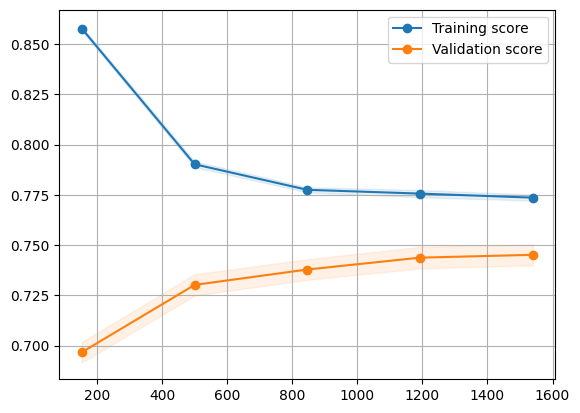

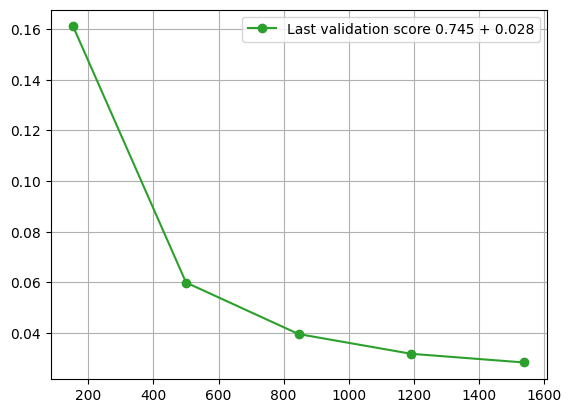

CPU times: user 577 ms, sys: 447 ms, total: 1.02 s
Wall time: 5min 36s


In [6]:
%%time

simple_average = VotingRegressor(models)

train_sizes, train_scores, test_scores = learning_curve(
    simple_average,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

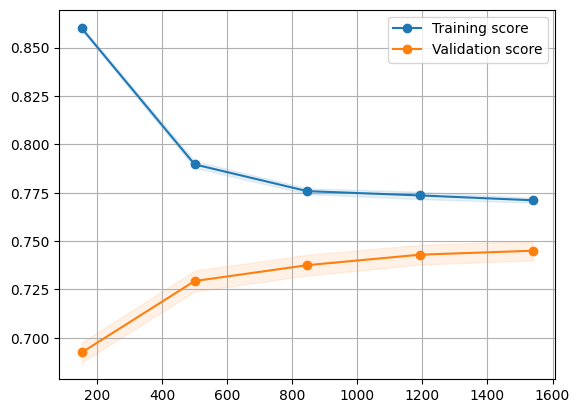

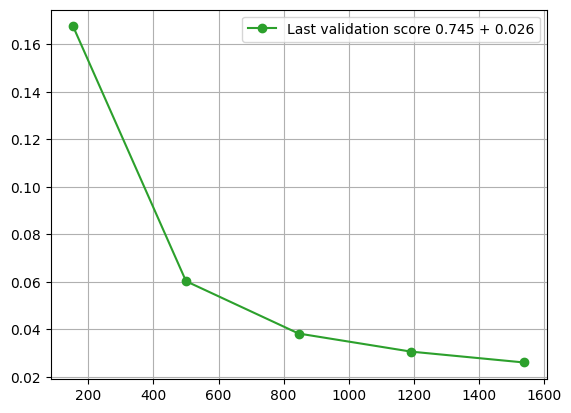

CPU times: user 547 ms, sys: 167 ms, total: 714 ms
Wall time: 5min 34s


In [7]:
%%time

weights = [1 / 0.029, 1 / 0.017, 1 / 0.032]
weighted_average = VotingRegressor(models, weights=weights)

train_sizes, train_scores, test_scores = learning_curve(
    weighted_average,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Stacking

In [8]:
def average_linear_regressions_fits(features, targets, n_splits=5, **kwargs):
    avg_model = LinearRegression(**kwargs)
    kfolder = KFold(n_splits=n_splits, shuffle=False)
    models = []
    for train_indices, _ in kfolder.split(features):
        model_ = clone(avg_model)
        model_.fit(features[train_indices, ...], targets[train_indices, ...])
        models.append(model_)
    avg_model.coef_ = np.mean([model.coef_ for model in models], axis=0)
    avg_model.intercept_ = np.mean([model.intercept_ for model in models], axis=0)
    return avg_model

class StackingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, aggregation, n_splits=5):
        self.estimators = estimators
        self.estimators_ = None
        self.aggregation = aggregation
        self.final_estimator_ = None
        self.n_splits = n_splits

    def fit(self, features, targets):
        self.estimators_ = []
        for estimator in self.estimators:
            estimator_ = clone(estimator)
            estimator_.fit(features, targets)
            self.estimators_.append(estimator_)

        predictions = [est.predict(features) for est in self.estimators_]
        if self.aggregation == 'stack':
            # fits a non-decreasing linear map R^{n_estimators} --> R
            model = average_linear_regressions_fits(
                np.stack([pred.ravel() for pred in predictions], axis=1),
                targets.ravel(),
                n_splits=self.n_splits,
                fit_intercept=False,
                positive=True,
            )
        else:  # self.aggregation == 'concatenate':
            # fits a linear map R^{n_estimators * n_features} --> R^{n_targets}
            model = average_linear_regressions_fits(
                np.concatenate(predictions, axis=1),
                targets,
                n_splits=self.n_splits,
                fit_intercept=False,
            )
        self.final_estimator_ = model
        return self

    def predict(self, features):
        predictions = [est.predict(features) for est in self.estimators_]
        return (
            np.average(np.array(predictions), axis=0, weights=self.final_estimator_.coef_)
            if self.aggregation == 'stack' else
            self.final_estimator_.predict(np.concatenate(predictions, axis=1))
        )

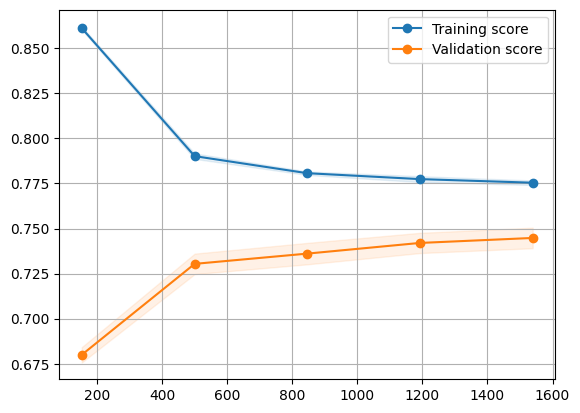

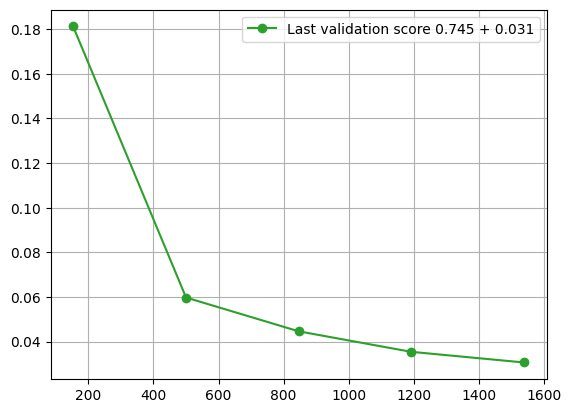

CPU times: user 529 ms, sys: 148 ms, total: 677 ms
Wall time: 5min 32s


In [9]:
%%time

stacked_model = StackingRegressor(estimators=models, aggregation='stack')

train_sizes, train_scores, test_scores = learning_curve(
    stacked_model,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

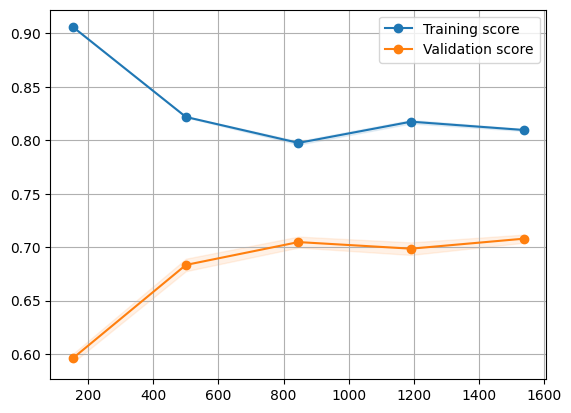

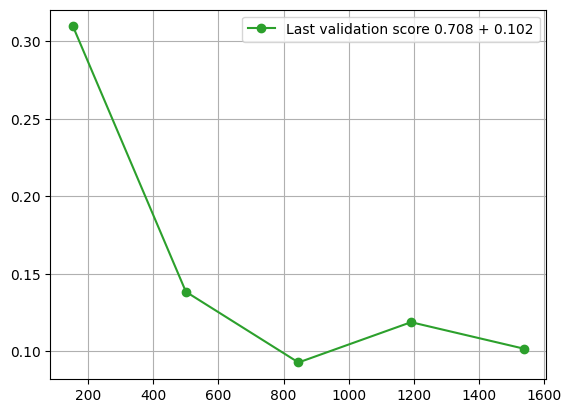

CPU times: user 520 ms, sys: 172 ms, total: 692 ms
Wall time: 5min 37s


In [10]:
%%time

stacked_model = StackingRegressor(estimators=models, aggregation='concat')

train_sizes, train_scores, test_scores = learning_curve(
    stacked_model,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Score on test

In [11]:
weights = [1 / 0.029, 1 / 0.017, 1 / 0.032]
weighted_average = VotingRegressor(models, weights=weights)

fitted_model, preds = fit_predict_sklearn_model(
    train_features, train_targets, test_features, test_targets,
    weighted_average,
)
join_truth_and_score(preds, data['test_days'], test_targets)

0.7403112714359691